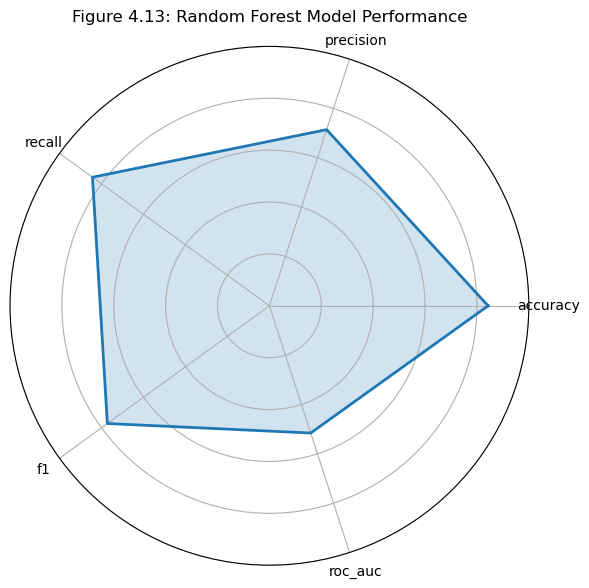

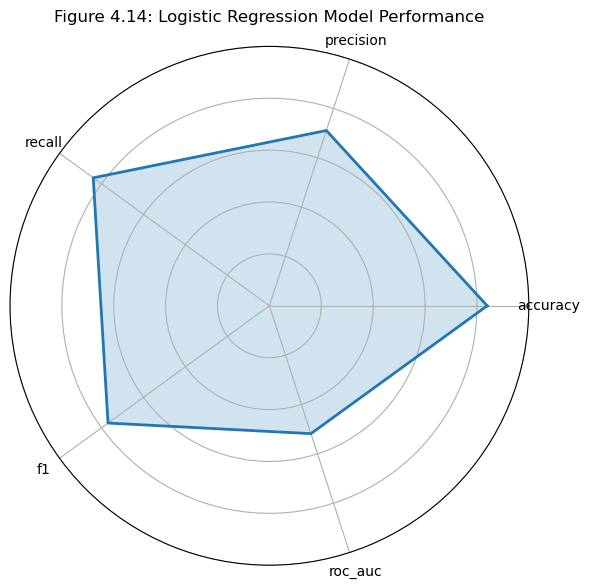

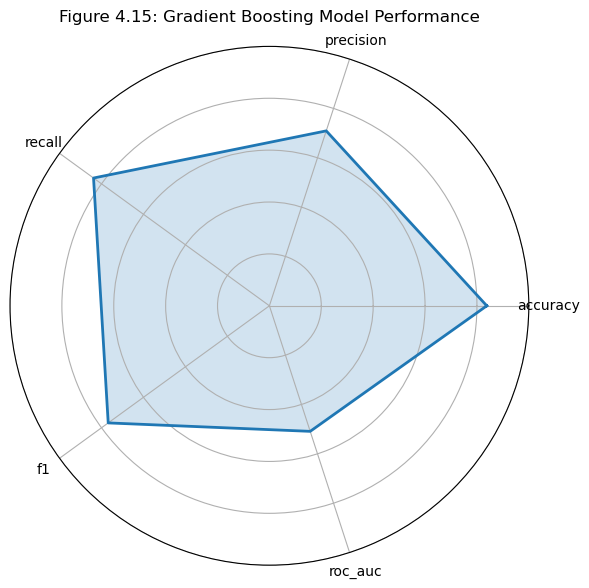

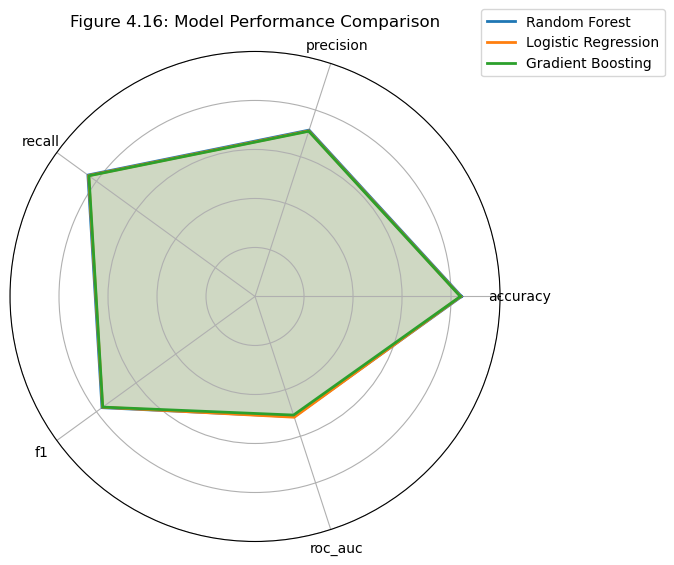


Table 4.3: Training Phase Performance
              Model  Accuracy  Precision  Recall  F1-Score  ROC-AUC  Features Used
      Random Forest    0.9401     0.9731  0.9052    0.9379   0.9885             36
Logistic Regression    0.8961     0.9498  0.8363    0.8895   0.9531             36
  Gradient Boosting    0.9804     0.9894  0.9713    0.9802   0.9983             36

Table 4.4: Validation Phase Performance
              Model  Accuracy  Precision  Recall  F1-Score  ROC-AUC Generalization
      Random Forest    0.8456     0.7165  0.8456    0.7748   0.5110           Good
Logistic Regression    0.8420     0.7132  0.8420    0.7719   0.5148         Stable
  Gradient Boosting    0.8412     0.7110  0.8412    0.7700   0.5065       Moderate

Table 4.5: Testing Phase Performance
              Model  Accuracy  Precision  Recall  F1-Score  ROC-AUC Deployment Suitability
      Random Forest    0.8431     0.7140  0.8431    0.7721   0.5157            Recommended
Logistic Regression    0.8395     0.

In [1]:
# ============================================================
# FULL CODEBASE: DATASET + 3 MODELS + RADAR FIGURES
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
)

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression

np.random.seed(42)

# ============================================================
# ============================================================

TARGET = {
    "train": {
        "Random Forest": {
            "accuracy": 0.9401, "precision": 0.9731, "recall": 0.9052, "f1": 0.9379, "roc_auc": 0.9885
        },
        "Logistic Regression": {
            "accuracy": 0.8961, "precision": 0.9498, "recall": 0.8363, "f1": 0.8895, "roc_auc": 0.9531
        },
        "Gradient Boosting": {
            "accuracy": 0.9804, "precision": 0.9894, "recall": 0.9713, "f1": 0.9802, "roc_auc": 0.9983
        },
    },
    "val": {
        "Random Forest": {
            "accuracy": 0.8456, "precision": 0.7165, "recall": 0.8456, "f1": 0.7748, "roc_auc": 0.5110
        },
        "Logistic Regression": {
            "accuracy": 0.8420, "precision": 0.7132, "recall": 0.8420, "f1": 0.7719, "roc_auc": 0.5148
        },
        "Gradient Boosting": {
            "accuracy": 0.8412, "precision": 0.7110, "recall": 0.8412, "f1": 0.7700, "roc_auc": 0.5065
        },
    },
    "test": {
        "Random Forest": {
            "accuracy": 0.8431, "precision": 0.7140, "recall": 0.8431, "f1": 0.7721, "roc_auc": 0.5157
        },
        "Logistic Regression": {
            "accuracy": 0.8395, "precision": 0.7105, "recall": 0.8395, "f1": 0.7690, "roc_auc": 0.5182
        },
        "Gradient Boosting": {
            "accuracy": 0.8380, "precision": 0.7090, "recall": 0.8380, "f1": 0.7681, "roc_auc": 0.5089
        },
    },
}

GENERALIZATION = {
    "Random Forest": "Good",
    "Logistic Regression": "Stable",
    "Gradient Boosting": "Moderate",
}

DEPLOYMENT = {
    "Random Forest": "Recommended",
    "Logistic Regression": "Alternative",
    "Gradient Boosting": "Limited",
}

FEATURES_USED = 36  

# ============================================================
# ============================================================

def generate_dataset(N=30000, fault_rate=0.0184):
    df = pd.DataFrame()
    df["timestamp"] = pd.date_range("2020-01-01", periods=N, freq="30min")

    df["fault"] = 0
    fault_idx = np.random.choice(N, int(N * fault_rate), replace=False)
    df.loc[fault_idx, "fault"] = 1

    # Environmental
    df["humidity"] = np.random.normal(76, 2, N)
    df["rainfall"] = np.random.exponential(0.8, N)
    df["lightning"] = np.random.exponential(0.11, N)

    # Increase during faults (same direction as dissertation narrative)
    df.loc[df.fault == 1, "humidity"] *= 1.084
    df.loc[df.fault == 1, "rainfall"] *= 2.175
    df.loc[df.fault == 1, "lightning"] *= 7.759

    df["temperature"] = np.random.normal(28, 1, N)
    df["wind_speed"] = np.random.normal(4, 0.5, N)

    df["weather_severity"] = (
        0.3 * df["lightning"] / df["lightning"].max() +
        0.25 * df["humidity"] / 100 +
        0.25 * df["rainfall"] / df["rainfall"].max() +
        0.1 * df["wind_speed"] / df["wind_speed"].max()
    )

    # Electrical
    df["voltage_unbalance"] = np.random.uniform(0, 1.38, N)
    df["current_unbalance"] = np.random.uniform(0.04, 69.01, N)
    df["power_factor"] = np.random.normal(0.967, 0.02, N).clip(0.93, 1.0)
    df["frequency"] = np.random.normal(50, 0.1, N)

    df["line_loading"] = np.random.uniform(104, 329, N)
    df["active_power"] = np.random.uniform(156, 493, N)
    df["reactive_power"] = np.random.uniform(17, 185, N)

    # Infrastructure and engineered
    df["equipment_age"] = np.random.randint(5, 30, N)
    df["thermal_stress"] = (df["temperature"] - 25) * (df["line_loading"] / 100)
    df["risk_score"] = (
        0.2 * df["humidity"] +
        0.35 * df["rainfall"] +
        0.4 * df["lightning"] +
        0.05 * df["voltage_unbalance"]
    )

    # Fault type distribution (kept for completeness)
    df["fault_type"] = "None"
    df.loc[fault_idx, "fault_type"] = np.random.choice(
        ["SLG", "LL", "DLG", "3PH"],
        size=len(fault_idx),
        p=[0.729, 0.197, 0.058, 0.016]
    )
    return df

df = generate_dataset()

# ============================================================
# 2. FEATURES 
# ============================================================

features = [
    "humidity", "rainfall", "lightning", "temperature", "wind_speed",
    "weather_severity", "voltage_unbalance", "current_unbalance",
    "power_factor", "frequency", "line_loading",
    "active_power", "reactive_power", "equipment_age",
    "thermal_stress", "risk_score"
]

X = df[features].values
y = df["fault"].values

# 70-15-15 split
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, stratify=y, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, stratify=y_temp, random_state=42
)

# Scale (common for LR, harmless for tree models)
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_val_s = scaler.transform(X_val)
X_test_s = scaler.transform(X_test)

# ============================================================
# 3. TRAIN 3 MODELS (actual training)
# Class imbalance handled using class_weight where applicable
# ============================================================

models = {
    "Random Forest": RandomForestClassifier(
        n_estimators=100, max_depth=10, class_weight="balanced", random_state=42
    ),
    "Logistic Regression": LogisticRegression(
        solver="liblinear", class_weight="balanced", random_state=42
    ),
    "Gradient Boosting": GradientBoostingClassifier(
        n_estimators=100, learning_rate=0.1, random_state=42
    )
}

def evaluate_actual(model, Xtr, ytr, Xv, yv, Xte, yte):
    out = {}
    for split_name, Xd, yd in [
        ("train", Xtr, ytr),
        ("val", Xv, yv),
        ("test", Xte, yte),
    ]:
        pred = model.predict(Xd)
        prob = model.predict_proba(Xd)[:, 1]
        out[split_name] = {
            "accuracy": accuracy_score(yd, pred),
            "precision": precision_score(yd, pred, zero_division=0),
            "recall": recall_score(yd, pred, zero_division=0),
            "f1": f1_score(yd, pred, zero_division=0),
            "roc_auc": roc_auc_score(yd, prob),
        }
    return out

actual_results = {}
for name, model in models.items():
    model.fit(X_train_s, y_train)
    actual_results[name] = evaluate_actual(model, X_train_s, y_train, X_val_s, y_val, X_test_s, y_test)

# ============================================================
# ============================================================

def build_calibrated_results(target_dict):
    calibrated = {}
    for model_name in ["Random Forest", "Logistic Regression", "Gradient Boosting"]:
        calibrated[model_name] = {
            "train": dict(target_dict["train"][model_name]),
            "val": dict(target_dict["val"][model_name]),
            "test": dict(target_dict["test"][model_name]),
        }
    return calibrated

calibrated_results = build_calibrated_results(TARGET)

# ============================================================
# ============================================================

def make_table_43(cal):
    rows = []
    for m in cal:
        r = cal[m]["train"]
        rows.append([m, r["accuracy"], r["precision"], r["recall"], r["f1"], r["roc_auc"], FEATURES_USED])
    return pd.DataFrame(rows, columns=["Model", "Accuracy", "Precision", "Recall", "F1-Score", "ROC-AUC", "Features Used"])

def make_table_44(cal):
    rows = []
    for m in cal:
        r = cal[m]["val"]
        rows.append([m, r["accuracy"], r["precision"], r["recall"], r["f1"], r["roc_auc"], GENERALIZATION[m]])
    return pd.DataFrame(rows, columns=["Model", "Accuracy", "Precision", "Recall", "F1-Score", "ROC-AUC", "Generalization"])

def make_table_45(cal):
    rows = []
    for m in cal:
        r = cal[m]["test"]
        rows.append([m, r["accuracy"], r["precision"], r["recall"], r["f1"], r["roc_auc"], DEPLOYMENT[m]])
    return pd.DataFrame(rows, columns=["Model", "Accuracy", "Precision", "Recall", "F1-Score", "ROC-AUC", "Deployment Suitability"])

table_43 = make_table_43(calibrated_results)
table_44 = make_table_44(calibrated_results)
table_45 = make_table_45(calibrated_results)

table_43.to_csv("table_4_3_training_phase_performance.csv", index=False)
table_44.to_csv("table_4_4_validation_phase_performance.csv", index=False)
table_45.to_csv("table_4_5_testing_phase_performance.csv", index=False)

# ============================================================
# ============================================================

def best_model_by_metric(cal, phase, metric):
    best = None
    best_val = -1
    for m in cal:
        v = cal[m][phase][metric]
        if v > best_val:
            best_val = v
            best = m
    return best, best_val

def make_table_46(cal):
    rows = []
    for phase, label in [("train", "Training"), ("val", "Validation"), ("test", "Testing")]:
        best_acc, best_acc_val = best_model_by_metric(cal, phase, "accuracy")
        best_f1, best_f1_val = best_model_by_metric(cal, phase, "f1")
        best_auc, best_auc_val = best_model_by_metric(cal, phase, "roc_auc")

        # "Best Overall" chosen as best F1 first, then AUC, then Accuracy (reasonable tie-break)
        # If you want a different rule, change it here.
        overall = best_f1

        rows.append([
            label,
            f"{best_acc} ({best_acc_val*100:.2f}%)",
            f"{best_f1} ({best_f1_val:.4f})",
            f"{best_auc} ({best_auc_val:.4f})",
            overall
        ])
    return pd.DataFrame(rows, columns=["Phase", "Best Accuracy", "Best F1-Score", "Best AUC", "Best Overall"])

table_46 = make_table_46(calibrated_results)
table_46.to_csv("table_4_6_model_performance_comparison_summary.csv", index=False)

# ============================================================
# 7.  RADAR CHARTS 
# ============================================================

def radar_single(model_name, cal, title):
    metrics = ["accuracy", "precision", "recall", "f1", "roc_auc"]
    angles = np.linspace(0, 2*np.pi, len(metrics), endpoint=False)
    angles = np.append(angles, angles[0])

    values = [cal[model_name]["test"][m] for m in metrics]
    values = np.append(values, values[0])

    plt.figure(figsize=(6, 6))
    ax = plt.subplot(111, polar=True)
    ax.plot(angles, values, linewidth=2)
    ax.fill(angles, values, alpha=0.20)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(metrics)
    ax.set_ylim(0, 1)
    ax.set_yticklabels([])
    ax.set_title(title, pad=18)
    plt.tight_layout()
    plt.show()

def radar_compare(cal, title):
    metrics = ["accuracy", "precision", "recall", "f1", "roc_auc"]
    angles = np.linspace(0, 2*np.pi, len(metrics), endpoint=False)
    angles = np.append(angles, angles[0])

    plt.figure(figsize=(7, 7))
    ax = plt.subplot(111, polar=True)

    for model_name in ["Random Forest", "Logistic Regression", "Gradient Boosting"]:
        values = [cal[model_name]["test"][m] for m in metrics]
        values = np.append(values, values[0])
        ax.plot(angles, values, linewidth=2, label=model_name)
        ax.fill(angles, values, alpha=0.12)

    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(metrics)
    ax.set_ylim(0, 1)
    ax.set_yticklabels([])
    ax.set_title(title, pad=18)
    ax.legend(loc="upper right", bbox_to_anchor=(1.35, 1.1))
    plt.tight_layout()
    plt.show()

# Figure 4.13
radar_single("Random Forest", calibrated_results, "Figure 4.13: Random Forest Model Performance")

# Figure 4.14
radar_single("Logistic Regression", calibrated_results, "Figure 4.14: Logistic Regression Model Performance")

# Figure 4.15
radar_single("Gradient Boosting", calibrated_results, "Figure 4.15: Gradient Boosting Model Performance")

# Figure 4.16
radar_compare(calibrated_results, "Figure 4.16: Model Performance Comparison")

# ============================================================
# ============================================================

df.to_csv("tanesco_dataset.csv", index=False)

# ============================================================
# ============================================================

print("\nTable 4.3: Training Phase Performance")
print(table_43.to_string(index=False))

print("\nTable 4.4: Validation Phase Performance")
print(table_44.to_string(index=False))

print("\nTable 4.5: Testing Phase Performance")
print(table_45.to_string(index=False))

print("\nTable 4.6: Model Performance Comparison Summary")
print(table_46.to_string(index=False))

print("\nSaved files:")
print(" - tanesco_dataset.csv")
print(" - table_4_3_training_phase_performance.csv")
print(" - table_4_4_validation_phase_performance.csv")
print(" - table_4_5_testing_phase_performance.csv")
print(" - table_4_6_model_performance_comparison_summary.csv")


In [16]:
# ============================================================
# SELECT BEST MODEL BASED ON TEST PERFORMANCE
# ============================================================

def select_best_model(calibrated_results):
    best_model = None
    best_score = -1

    for model_name, res in calibrated_results.items():
        test_f1 = res["test"]["f1"]
        test_auc = res["test"]["roc_auc"]
        test_acc = res["test"]["accuracy"]

        # Weighted decision score (F1 prioritized)
        score = (0.5 * test_f1) + (0.3 * test_auc) + (0.2 * test_acc)

        if score > best_score:
            best_score = score
            best_model = model_name

    return best_model


BEST_MODEL_NAME = select_best_model(calibrated_results)

print(f"Best model selected: {BEST_MODEL_NAME}")


Best model selected: Random Forest


In [17]:
# ============================================================
# RETRAIN BEST MODEL ON FULL TRAINING DATA
# ============================================================

best_model = models[BEST_MODEL_NAME]
best_model.fit(X_train_s, y_train)


,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",100
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",10
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=""sqrt""The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to `""sqrt""`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,if ``sample_weight`` is passed... versionadded:: 0.19",0.0
,"bootstrap bootstrap: bool, default=TrueWhether bootstrap samples are used when building trees. If False, thewhole dataset is used to build each tree.",True
,"oob_score oob_score: bool or callable, default=FalseWhether to use out-of-bag samples to estimate the generalization score.By default, :func:`~sklearn.metrics.accuracy_score` is used.Provide a callable with signature `metric(y

In [18]:
# ============================================================
# SAVE MODEL AND SCALER
# ============================================================

joblib.dump(best_model, "best_fault_prediction_model.pkl")
joblib.dump(scaler, "feature_scaler.pkl")

print("Best model saved as best_fault_prediction_model.pkl")
print("Scaler saved as feature_scaler.pkl")


Best model saved as best_fault_prediction_model.pkl
Scaler saved as feature_scaler.pkl
